In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Caltech/Senior/BEM120

[Errno 2] No such file or directory: 'drive/MyDrive/Caltech/Senior/BEM120'
/content/drive/MyDrive/Caltech/Senior/BEM120


DATA: https://www.kaggle.com/datasets/justinas/nba-players-data/data

In [ ]:
import pandas as pd

file_path3 = 'draftpicks.csv'
draftpicks = pd.read_csv(file_path3)

file_path4 = 'nba_stats.csv'
nba_stats = pd.read_csv(file_path4)

In [ ]:
columns_to_remove = ['Unnamed: 0_level_0 Rk']
draftpicks = draftpicks.drop(columns=columns_to_remove, errors='ignore')

draftpicks = draftpicks.rename(columns={
    'Unnamed: 1_level_0 Pk': 'pick_number',
    'Unnamed: 2_level_0 Tm': 'Team',
    'Unnamed: 5_level_0 Yrs': 'career_length',
    'Round 1 College': 'college_team'
})

In [ ]:
columns_to_remove = ['career_length',
       'Totals G', 'Totals MP', 'Totals PTS', 'Totals TRB', 'Totals AST',
       'Shooting FG%', 'Shooting 3P%', 'Shooting FT%', 'Per Game MP',
       'Per Game PTS', 'Per Game TRB', 'Per Game AST', 'Advanced WS',
       'Advanced WS/48', 'Advanced BPM', 'Advanced VORP']
draftpicks = draftpicks.drop(columns=columns_to_remove, errors='ignore')

In [ ]:
nba_stats_sorted = nba_stats.sort_values(by=['player_name', 'season'])
nba_stats_sorted['season_rank'] = nba_stats_sorted.groupby('player_name').cumcount() + 1

filtered = nba_stats_sorted[nba_stats_sorted['season_rank'].isin([1, 2, 3])].copy()

filtered['season_rank_priority'] = filtered['season_rank'].apply(lambda x: {3: 1, 2: 2, 1: 3}[x])

year3 = filtered.sort_values(by=['player_name', 'season_rank_priority']).drop_duplicates('player_name')

year3 = year3.drop(columns=['season_rank', 'season_rank_priority'])

In [ ]:
year3 = year3.rename(columns={'player_name': 'name'})
draftpicks = draftpicks.rename(columns={'Player': 'name'})

In [ ]:
print(year3.columns)
print(draftpicks.columns)

Index(['Unnamed: 0', 'name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')
Index(['pick_number', 'Team', 'name', 'college_team', 'Draft_Year'], dtype='object')


In [ ]:
pick_success = pd.merge(draftpicks, year3, on='name', how='inner')
print(pick_success)

     pick_number Team            name college_team  Draft_Year  Unnamed: 0  \
0              1  NJN   Kenyon Martin   Cincinnati        2000        2696   
1              2  VAN  Stromile Swift          LSU        2000        2829   
2              3  LAC    Darius Miles          NaN        2000        2931   
3              4  CHI    Marcus Fizer   Iowa State        2000        2719   
4              5  ORL     Mike Miller      Florida        2000        2670   
...          ...  ...             ...          ...         ...         ...   
1082          48  MIN   Kendall Brown       Baylor        2022       12699   
1083          49  CLE   Isaiah Mobley          USC        2022       12657   
1084          51  GSW   Tyrese Martin        UConn        2022       12394   
1085          53  BOS      JD Davison      Alabama        2022       12779   
1086          57  POR   Jabari Walker     Colorado        2022       12785   

     team_abbreviation   age  player_height  player_weight  ...

In [ ]:
print(pick_success.columns)

Index(['pick_number', 'Team', 'name', 'college_team', 'Draft_Year',
       'Unnamed: 0', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')


In [ ]:
df = pick_success.copy()

#Adjusted version of Dean Oliver Four Factors (Don't have stats to do defensive one)
df['scoring_score'] = (
    df['pts'] * df['gp'] * df['ts_pct']
)

df['assist_score'] = (
    df['ast'] * df['gp'] * df['ast_pct']
)

df['rebound_score'] = (
    df['reb'] * df['gp'] * df['oreb_pct'] * df['dreb_pct']
)

weight_1 = 0.55
weight_2 = 0.25
weight_3 = 0.2

df['performance_score'] = (
    df['scoring_score'] * weight_1 +
    df['assist_score'] * weight_2 +
    df['rebound_score'] * weight_3
)

df['pick_number'] = pd.to_numeric(df['pick_number'], errors='coerce')

df['performance_rank'] = df.groupby('Draft_Year')['performance_score'].rank(method='min', ascending=False)

df['draft_delta'] = df['pick_number'] - df['performance_rank']

def label_outcome(delta):
    if delta < -10:
        return 'Draft Bust'
    elif delta > 10:
        return 'Draft Steal'
    else:
        return 'Drafted About Right'

df['draft_result'] = df['draft_delta'].apply(label_outcome)

df_sorted = df.sort_values(by='draft_delta')

print(df_sorted[['name', 'Draft_Year', 'pick_number', 'performance_score', 'performance_rank', 'draft_delta', 'draft_result']].head(10))
print("\nTop Draft Steals:")
print(df_sorted[df_sorted['draft_result'] == 'Draft Steal'].head(10))
print("\nTop Draft Busts:")
print(df_sorted[df_sorted['draft_result'] == 'Draft Bust'].tail(10))

                  name  Draft_Year  pick_number  performance_score  \
396    Hasheem Thabeet        2009            2          11.849736   
590    Anthony Bennett        2013            1           7.076559   
358      Joe Alexander        2008            8           0.663149   
259      Adam Morrison        2006            3          17.694763   
553        Royce White        2012           16           0.000000   
1000      Joshua Primo        2021           12           8.263968   
220   Yaroslav Korolev        2005           12           2.316196   
306          Greg Oden        2007            1          21.036350   
838       Zhaire Smith        2018           16           1.369130   
266      Mouhamed Sene        2006           10           8.267419   

      performance_rank  draft_delta draft_result  
396               44.0        -42.0   Draft Bust  
590               39.0        -38.0   Draft Bust  
358               44.0        -36.0   Draft Bust  
259               39.0   

--- Draft Outcome Analysis ---

Draft Outcome Percentages:
draft_result
Drafted About Right    53.82%
Draft Steal            29.25%
Draft Bust             16.93%
Name: count, dtype: object


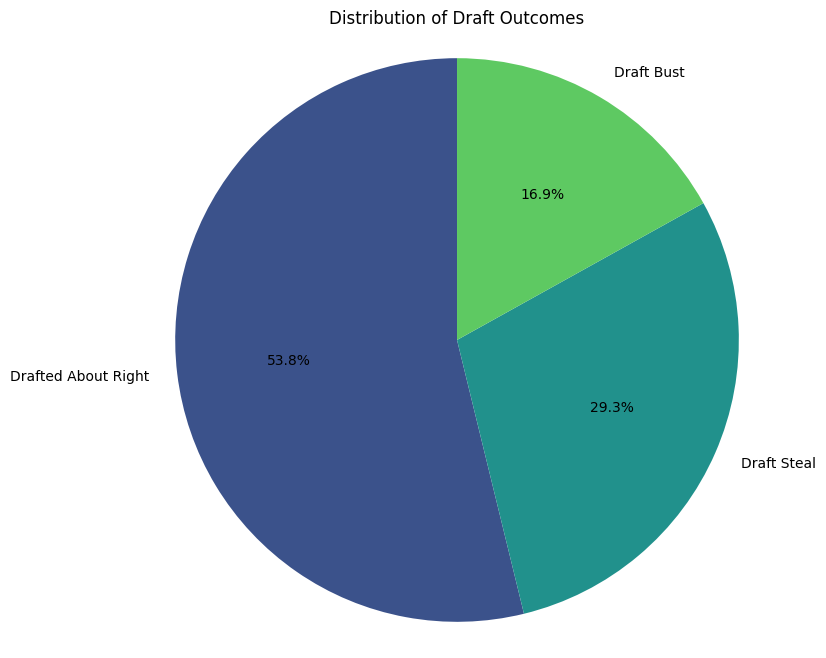

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("--- Draft Outcome Analysis ---")
category_counts = df['draft_result'].value_counts()

category_percentages = (category_counts / len(df)) * 100

category_percentages_formatted = category_percentages.round(2).astype(str) + '%'

print("\nDraft Outcome Percentages:")
print(category_percentages_formatted)

plt.figure(figsize=(8, 8))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis", len(category_percentages)))
plt.title('Distribution of Draft Outcomes')
plt.axis('equal')
plt.show()


--- Team Performance Analysis (Steals & Busts) ---

Top 5 Teams with Most Draft Steals:
draft_result  Draft Steal
Team                     
DET                    18
SAS                    18
PHI                    15
MIL                    15
BOS                    15

Top 5 Teams with Most Draft Busts:
draft_result  Draft Bust
Team                    
CLE                    9
MIL                    9
PHO                    9
NYK                    8
BOS                    8


<Figure size 1400x800 with 0 Axes>

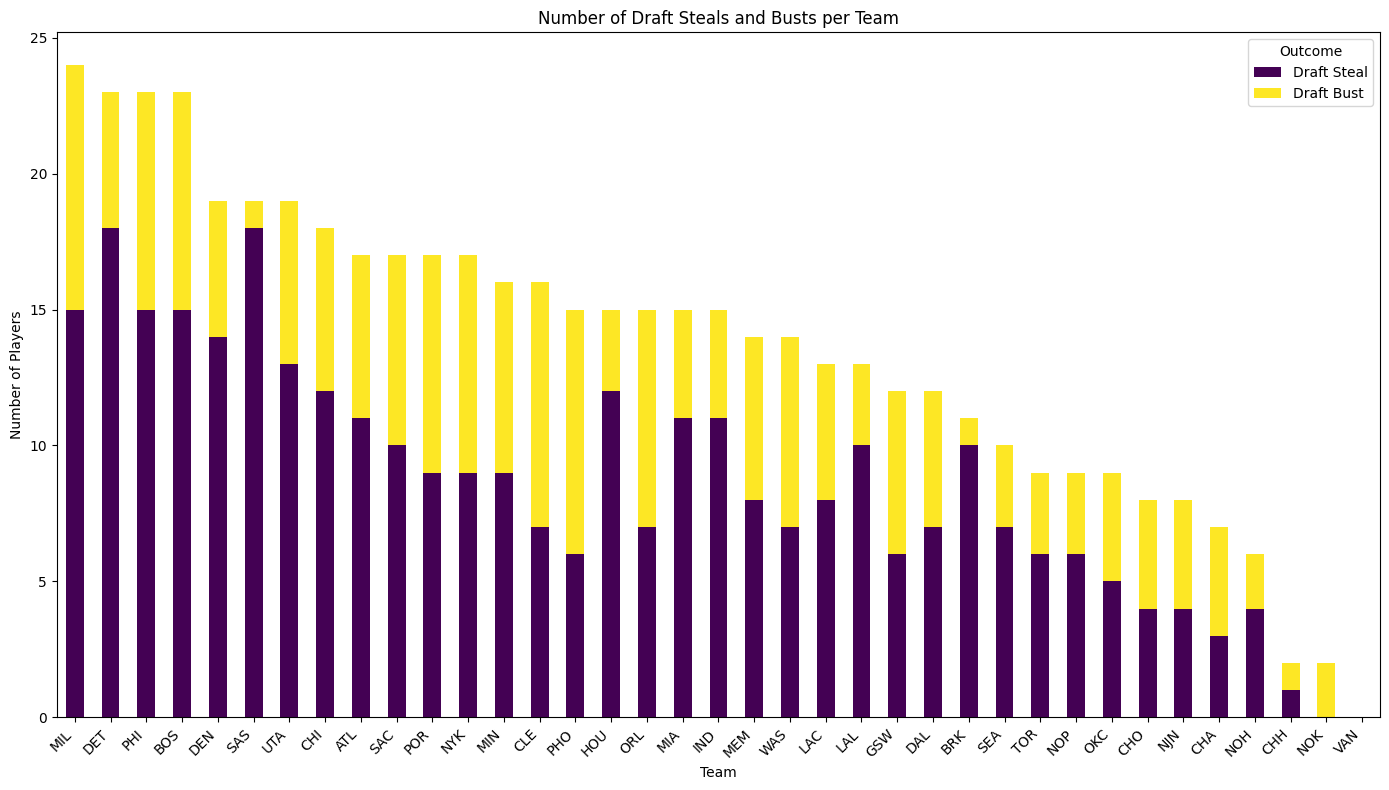

In [ ]:
print("\n--- Team Performance Analysis (Steals & Busts) ---")
team_outcomes = df.groupby(['Team', 'draft_result']).size().unstack(fill_value=0)

top_steals = team_outcomes.sort_values(by='Draft Steal', ascending=False).head(5)
top_busts = team_outcomes.sort_values(by='Draft Bust', ascending=False).head(5)

print("\nTop 5 Teams with Most Draft Steals:")
print(top_steals[['Draft Steal']])

print("\nTop 5 Teams with Most Draft Busts:")
print(top_busts[['Draft Bust']])

plt.figure(figsize=(14, 8))

plot_data = team_outcomes[['Draft Steal', 'Draft Bust']]

plot_data['Total'] = plot_data['Draft Steal'] + plot_data['Draft Bust']
plot_data = plot_data.sort_values(by='Total', ascending=False).drop(columns='Total')

plot_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('Number of Draft Steals and Busts per Team')
plt.xlabel('Team')
plt.ylabel('Number of Players')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()


--- Player Performance Score Analysis ---

Top 10 Players by Performance Score:
                 name  Draft_Year  performance_score
0        Kevin Durant        2007         832.308899
1        LeBron James        2003         816.491418
2   Amar'e Stoudemire        2002         710.466022
3         Dwyane Wade        2003         687.084558
4        Derrick Rose        2008         670.764266
5     Carmelo Anthony        2003         664.491440
6          Chris Paul        2005         650.916608
7  Karl-Anthony Towns        2015         630.396746
8     Anthony Edwards        2020         619.744025
9   Russell Westbrook        2008         602.707859


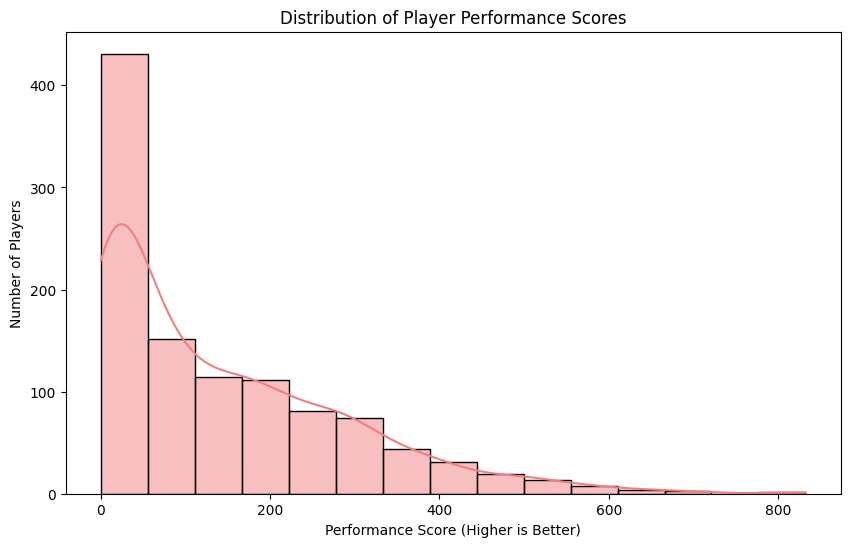

<ipython-input-68-36560da8e967>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='performance_score', data=top_players_by_score, palette='Blues_d')


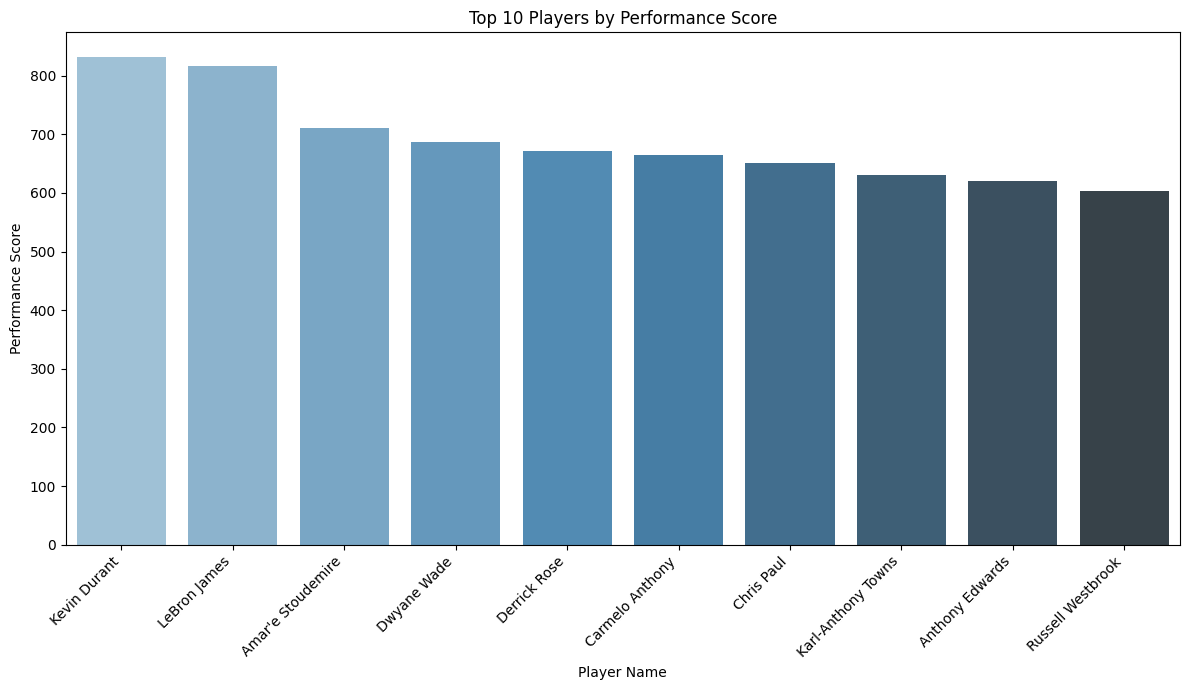

In [ ]:
print("\n--- Player Performance Score Analysis ---")
ranked_by_score_df = df.sort_values(by='performance_score', ascending=False)

output_score_df = ranked_by_score_df[['name', 'Draft_Year', 'performance_score']].reset_index(drop=True)

print("\nTop 10 Players by Performance Score:")
print(output_score_df.head(10))

plt.figure(figsize=(10, 6))
sns.histplot(df['performance_score'], bins=15, kde=True, color='lightcoral')
plt.title('Distribution of Player Performance Scores')
plt.xlabel('Performance Score (Higher is Better)')
plt.ylabel('Number of Players')
plt.show()

top_n_score = 10
top_players_by_score = output_score_df.head(top_n_score)

plt.figure(figsize=(12, 7))
sns.barplot(x='name', y='performance_score', data=top_players_by_score, palette='Blues_d')
plt.title(f'Top {top_n_score} Players by Performance Score')
plt.xlabel('Player Name')
plt.ylabel('Performance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
ordered_df = df.sort_values(by=['Draft_Year', 'performance_rank'])
final_df = ordered_df[['name', 'Draft_Year', 'performance_rank']].reset_index(drop=True)
print(final_df)

final_df.to_csv('draft_performance_rank.csv', index=False)

                    name  Draft_Year  performance_rank
0           Michael Redd        2000               1.0
1          Kenyon Martin        2000               2.0
2          Desmond Mason        2000               3.0
3        Morris Peterson        2000               4.0
4            Mike Miller        2000               5.0
...                  ...         ...               ...
1082  Vince Williams Jr.        2022              40.0
1083          JD Davison        2022              41.0
1084       Tyrese Martin        2022              42.0
1085       Kendall Brown        2022              43.0
1086        Trevor Keels        2022              44.0

[1087 rows x 3 columns]
